In [1]:
from __future__ import print_function

import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import SeparableConv1D, Conv1D, MaxPooling1D
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

save_dir = os.path.join(os.getcwd(), 'saved_models')

from IPython.display import clear_output
from keras_helper import PlotProgress

%matplotlib inline

Using TensorFlow backend.


In [2]:
num_classes = 6

In [3]:
def get_confusion_matrix(Y, Y_hat):
    report = classification_report(
        y_true=Y.argmax(axis=1),
        y_pred=Y_hat.argmax(axis=1),
        labels=list(label_mapping.keys()),
        target_names=list(label_mapping.values())
    )
    return report

In [4]:
class PlotProgress(keras.callbacks.Callback):
    
    def __init__(self, entities=['loss']):
        self.entities = entities
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = {}
        self.val_losses = {}
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        
        for entity in self.entities:
            self.losses.update({
                '{}'.format(entity) : self.losses.get('{}'.format(entity), list()) + [logs.get('{}'.format(entity))]
            })
            self.val_losses.update({
                'val_{}'.format(entity) : self.val_losses.get('val_{}'.format(entity), list()) + [logs.get('val_{}'.format(entity))]
            })
        self.i += 1
        
        clear_output(wait=True)
        ncol = 2
        nrow = int(len(self.entities) / ncol) + 1
        plt.figure(figsize=(12, 8))
        
        for idx, entity in enumerate(self.entities):
            plt.subplot(nrow, ncol, idx + 1)
            plt.plot(self.x, self.losses.get("{}".format(entity)), label="{}".format(entity))
            plt.plot(self.x, self.val_losses.get("val_{}".format(entity)), label="val_{}".format(entity))
            plt.xlabel('epoch')
            plt.title(entity)
            plt.legend()
        plt.show();

In [5]:
body_acc_x_train = pd.read_csv('../data/har/train/Inertial_Signals/body_acc_x_train.txt', sep='\s+', header=None)
body_acc_y_train = pd.read_csv('../data/har/train/Inertial_Signals/body_acc_y_train.txt', sep='\s+', header=None)
body_acc_z_train = pd.read_csv('../data/har/train/Inertial_Signals/body_acc_z_train.txt', sep='\s+', header=None)

total_acc_x_train = pd.read_csv('../data/har/train/Inertial_Signals/total_acc_x_train.txt', sep='\s+', header=None)
total_acc_y_train = pd.read_csv('../data/har/train/Inertial_Signals/total_acc_y_train.txt', sep='\s+', header=None)
total_acc_z_train = pd.read_csv('../data/har/train/Inertial_Signals/total_acc_z_train.txt', sep='\s+', header=None)

body_gyro_x_train = pd.read_csv('../data/har/train/Inertial_Signals/body_gyro_x_train.txt', sep='\s+', header=None)
body_gyro_y_train = pd.read_csv('../data/har/train/Inertial_Signals/body_gyro_y_train.txt', sep='\s+', header=None)
body_gyro_z_train = pd.read_csv('../data/har/train/Inertial_Signals/body_gyro_z_train.txt', sep='\s+', header=None)

y_train = pd.read_csv('../data/har/train/y_train.txt', sep='\s+', header=None).values

In [6]:
label_info = pd.read_csv('../data/har/activity_labels.txt', sep='\s+', header=None)
label_mapping = dict()

for index, row_data in label_info.iterrows():
    label_mapping.update({row_data[0] -1 : row_data[1]})

In [7]:
X_train = np.stack([body_acc_x_train,
                    body_acc_y_train,
                    body_acc_z_train,
                    total_acc_x_train,
                    total_acc_y_train,
                    total_acc_z_train,
                    body_gyro_x_train,
                    body_gyro_y_train,
                    body_gyro_z_train,
                   ], axis=-1)

In [8]:
encoder = OneHotEncoder(categories='auto')
Y_train = encoder.fit_transform(y_train).toarray()

In [9]:
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')

In [10]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, 
                                                      Y_train,
                                                      test_size=0.2,
                                                      random_state=123)

In [11]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((5881, 128, 9), (5881, 6), (1471, 128, 9), (1471, 6))

In [12]:
# # Main Model
# kernel_size = 32
# max_pool_size = 3
# dropout_rate = 0.25

# input_sample_size = X_train.shape[1:]

# model = Sequential()
# model.add(Conv1D(30, kernel_size, padding='same', input_shape=input_sample_size))
# model.add(Activation('relu'))
# model.add(MaxPooling1D(pool_size= max_pool_size))
# model.add(Dropout(dropout_rate))

# model.add(Conv1D(30, kernel_size, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling1D(pool_size= max_pool_size))
# model.add(Dropout(dropout_rate))

# model.add(Flatten())
# model.add(Dense(num_classes))
# model.add(Activation('softmax'))

In [13]:
kernel_size = 32
max_pool_size = 3
dropout_rate = 0.5

input_sample_size = X_train.shape[1:]

model = Sequential()
model.add(Conv1D(64, kernel_size, padding='same', input_shape=input_sample_size))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size= max_pool_size))
model.add(Dropout(dropout_rate))

model.add(Conv1D(32, kernel_size, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size= max_pool_size))
model.add(Dropout(dropout_rate))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 128, 64)           18496     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 42, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 42, 32)            65568     
_________________________________________________________________
activation_2 (Activation)    (None, 42, 32)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 14, 32)            0         
__________

In [15]:
opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


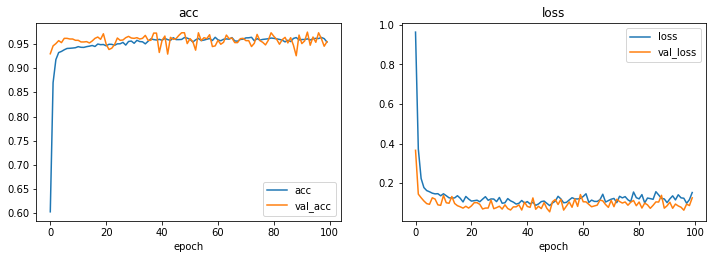

CPU times: user 3min 2s, sys: 58 s, total: 4min
Wall time: 2min 34s


In [16]:
%%time
batch_size = 64
epochs = 100

plot_progress = PlotProgress(entities=['acc', 'loss'])

save_path = './keras-saves/_latest.ckpt'
try:
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_valid, Y_valid),
              callbacks=[plot_progress],
              shuffle=True,
         )
except KeyboardInterrupt:
#     model.save(save_path)
    print('\nOutput saved to: "{}./*"'.format(save_path))

In [127]:
from keras.utils.vis_utils import plot_model

In [128]:
plot_model(model, show_shapes=True)

In [129]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [130]:
X_train.shape, Y_train.shape

((5881, 128, 9), (5881, 6))

In [131]:
print("Train Confusion Matrix\n", get_confusion_matrix(Y_train, model.predict(X_train)))
print("Validation Confusion Matrix\n", get_confusion_matrix(Y_valid, model.predict(X_valid)))

Train Confusion Matrix
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00       993
  WALKING_UPSTAIRS       1.00      1.00      1.00       847
WALKING_DOWNSTAIRS       1.00      1.00      1.00       778
           SITTING       0.98      0.90      0.94      1042
          STANDING       0.91      0.98      0.95      1096
            LAYING       1.00      1.00      1.00      1125

         micro avg       0.98      0.98      0.98      5881
         macro avg       0.98      0.98      0.98      5881
      weighted avg       0.98      0.98      0.98      5881

Validation Confusion Matrix
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00       233
  WALKING_UPSTAIRS       1.00      1.00      1.00       226
WALKING_DOWNSTAIRS       1.00      1.00      1.00       208
           SITTING       0.96      0.92      0.94       244
          STANDING       0.93      0.97    

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [ ]:
from keras import backend as K
layer_name = 'conv1d_16'
filter_index = 0

layer_output = layer_dict[layer_name].output

In [ ]:
layer_dict[layer_name].get_weights()[0].shape

In [ ]:
from keras.utils import plot_model

In [ ]:
plot_model(model, to_file='../model.png')

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [13]:
grouped_mean_spectrogram = spects.groupby(y_train).head(1).apply(
    lambda group: np.mean([specg for frequencies, times, specg in group], axis=0)
)

NameError: name 'spects' is not defined

In [ ]:
plt.figure(figsize=(20, 10))
for i in grouped_mean_spectrogram.index:
    plt.subplot(2, 3, i)
#     plt.yticks(frequencies)
    plt.imshow(grouped_mean_spectrogram[i], cmap='plasma')
    plt.title(label_mapping.get(i))

In [ ]:
plt.figure(figsize=(20, 20))

sample = 10
cat = 4

for i, (freqs, times, spec) in enumerate(spects.groupby(y_train).get_group(cat)[:sample]):
    plt.subplot(3, 4, i+1)
    plt.yticks(freqs)
    plt.imshow(spec, cmap='plasma')
    plt.title(label_mapping.get(cat))
